# Verify the Correctness of Exported Model and Compare the Performance

We choose PyTorch to export the ONNX model, and use Caffe2 and Tensorflow as backend.
After that, the outputs and performance of the three models are compared.

The ONNX Tutorial "Verify the Correctness of Exported Model and Compare the Performance" uses only Caffe2 as backend. But it fails when running the Caffe2 Model. In this notebook, we used a workaround to correct this issue. There are also some drawbacks of 

Reference : https://github.com/onnx/tutorials/blob/master/tutorials/CorrectnessVerificationAndPerformanceComparison.ipynb

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import numpy as np
import torch
import onnx
from onnx_tf.backend import prepare
import torch.nn as nn
import torch.nn.functional as F
import time

from caffe2.proto import caffe2_pb2
from caffe2.python import core
from torch.autograd import Variable
from caffe2.python.onnx.backend import Caffe2Backend
from caffe2.python.onnx.helper import c2_native_run_net, save_caffe2_net, load_caffe2_net




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






## Build MNIST Model

In [2]:
class MNIST(nn.Module):

    def __init__(self):
        super(MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

## Generate ONNX model from PyTorch

In [3]:
# Create a pytorch model.
pytorch_model = MNIST()
pytorch_model.train(False)

# Generate dummy inputs.

inputs = (Variable(torch.randn(3, 1, 28, 28), requires_grad=True), )

# Run the PyTorch exporter to generate an ONNX model.
torch.onnx.export(pytorch_model, inputs, "mnist_pytorch.onnx")

## Load ONNX Model

In [4]:
# Load the onnx model
onnx_model = onnx.load('mnist_pytorch.onnx')

# Check whether the onnx_model is valid or not.
print("Check the ONNX model.")
onnx.checker.check_model(onnx_model)

Check the ONNX model.


## Build Caffe2 Model from ONNX

Now, we have an ONNX model, let's turn it into a Caffe2 one.

In [5]:
# Convert the ONNX model to a Caffe2 model.
print("Convert the model to a Caffe2 model.")
init_net, predict_net = Caffe2Backend.onnx_graph_to_caffe2_net(onnx_model, device="CPU")

Convert the model to a Caffe2 model.


Caffe2 takes a list of numpy array as inputs. So we need to change the format.

In [6]:
# Prepare the inputs for Caffe2.
caffe2_inputs = [var.data.numpy() for var in inputs]

## Build TensorFlow Model from ONNX

In [7]:
# Prepare inputs for TensorFlow
tensorflow_inputs = [var.detach().numpy() for var in inputs]

In [8]:
# Convert the ONNX model to a TensorFlow model.
tf_rep = prepare(onnx_model)

## Running different models

Run PyTorch, Caffe2 and Tensorflow models separately, and get the results.

In [9]:
# Compute the results using the PyTorch model.
pytorch_results = pytorch_model(*inputs)

# Compute the results using the Caffe2 model.
# the function c2_native_run_net return 2 objects, the workspace and the results
# ws is an object representing a Caffe2 workspace an instance of the class Workspace from onnx_caffe2.workspace,
#This class makes it possible to work with workspaces more locally, and without forgetting 
#to deallocate everything in the end.
ws, caffe2_results = c2_native_run_net(init_net, predict_net, caffe2_inputs)

# Compute the results using the Tensorflow model.
tensorflow_results = tf_rep.run(tensorflow_inputs)

## Correctness Check of different models

Now we have the results, let's check the correctness of the exported model.
If no assertion fails, our model has achieved expected precision.

In [10]:
def correctness_check(expected_decimal = 5, iters = 5):

    for i in range(iters):
        
        # Generate input randomly but the same for each iteration
        pytorch_inputs = (Variable(torch.randn(3, 1, 28, 28), requires_grad=True), )
        caffe2_inputs = [var.data.numpy() for var in pytorch_inputs]
        tensorflow_inputs = [var.detach().numpy() for var in pytorch_inputs]
        
        # Calculate results of each iteration
        pytorch_results = pytorch_model(*pytorch_inputs)
        ws, caffe2_results = c2_native_run_net(init_net, predict_net, caffe2_inputs)
        tensorflow_results = tf_rep.run(tensorflow_inputs)
        
        
        # Check the decimal precision of the exported Caffe2 and Tensorflow.
        

        p, c, t = [[var.detach().numpy() for var in pytorch_results]], caffe2_results, tensorflow_results
        np.testing.assert_almost_equal(p, c, decimal=expected_decimal, 
                                       err_msg= "Desired precision not achieved between PyTorch and Caffe2")
        np.testing.assert_almost_equal(p, t, decimal=expected_decimal, 
                                       err_msg= "Desired precision not achieved between PyTorch and Tensorflow")
        np.testing.assert_almost_equal(c, t, decimal=expected_decimal, 
                                       err_msg= "Desired precision not achieved between Caffe2 and Tensorflow")
        print("The exported model achieves {}-decimal precision for iteration number : {}.".format(expected_decimal, i+1))

In [11]:
correctness_check(expected_decimal = 5, iters = 20)

The exported model achieves 5-decimal precision for iteration number : 1.
The exported model achieves 5-decimal precision for iteration number : 2.
The exported model achieves 5-decimal precision for iteration number : 3.
The exported model achieves 5-decimal precision for iteration number : 4.
The exported model achieves 5-decimal precision for iteration number : 5.
The exported model achieves 5-decimal precision for iteration number : 6.
The exported model achieves 5-decimal precision for iteration number : 7.
The exported model achieves 5-decimal precision for iteration number : 8.
The exported model achieves 5-decimal precision for iteration number : 9.
The exported model achieves 5-decimal precision for iteration number : 10.
The exported model achieves 5-decimal precision for iteration number : 11.
The exported model achieves 5-decimal precision for iteration number : 12.
The exported model achieves 5-decimal precision for iteration number : 13.
The exported model achieves 5-deci

## Performance Check of different models

The following code measures the performance of PyTorch, Caffe2 and Tensorflow models.
We report:
- Execution time per iteration
- Iterations per second

### Definition of a function that measures PyTorch model performance (Baseline)

In [12]:
def performance_pytorch_model(model, inputs, warmup_iters=3, main_iters=10):
    '''
     Run the model several times, and measure the execution time.
     Print the execution time per iteration (millisecond) and the number of iterations per second.
    '''
    for _i in range(warmup_iters):
        model(*inputs)
        
    total_time = 0.0
    execution_times = []
    for _i in range(main_iters):
        ts = time.time()
        model(*inputs)
        te = time.time()
        total_time += te - ts
        execution_times.append((te - ts)*1000)
    print("The PyTorch model execution time per iter is {} milliseconds, "
          "{} iters per second.".format(total_time / main_iters * 1000,
                                        main_iters / total_time))
    return execution_times

### Definition of a function that measures Caffe2 model performance

We decided to use this method instead of the builtin function benchmark_caffe2_model under caffe2.python.onnx.helper so that the same way of benchmarking would be apllied on all the frameworks.

In [13]:
 def performance_caffe2_model(init_net, predict_net,inputs, warmup_iters=3, main_iters=10):
    '''
     Run the model several times, and measure the execution time.
     Print the execution time per iteration (millisecond) and the number of iterations per second.
    '''
    for _i in range(warmup_iters):
        ws, caffe2_results = c2_native_run_net(init_net, predict_net, inputs)    
    execution_times = []
    total_time = 0.0
    for _i in range(main_iters):
        ts = time.time()
        ws, caffe2_results = c2_native_run_net(init_net, predict_net, inputs)
        te = time.time()
        total_time += te - ts
        execution_times.append((te - ts)*1000)
    print("The Caffe2 model execution time per iter is {} milliseconds, "
          "{} iters per second.".format(total_time / main_iters * 1000,
                                        main_iters / total_time))
    return execution_times

### Definition of a function that measures Tensorflow model performance

In [14]:
 def performance_tensorflow_model(model, inputs, warmup_iters=3, main_iters=10):
    '''
     Run the model several times, and measure the execution time.
     Print the execution time per iteration (millisecond) and the number of iterations per second.
    '''

    for _i in range(warmup_iters):
        output = tf_rep.run(inputs)
    
    execution_times = []
    total_time = 0.0
    for _i in range(main_iters):
        ts = time.time()
        output = tf_rep.run(inputs)
        te = time.time()
        total_time += te - ts
        execution_times.append((te - ts)*1000)
    print("The Tensorflow model execution time per iter is {} milliseconds, "
          "{} iters per second.".format(total_time / main_iters * 1000,
                                        main_iters / total_time))
    return execution_times

## Evaluation of results

In [15]:
import matplotlib.pyplot as plt
performce_models_dict = {'pytorch':[], 'caffe2':[], 'tensorflow': []}

The PyTorch model execution time per iter is 0.4846620559692383 milliseconds, 2063.2933560275874 iters per second.


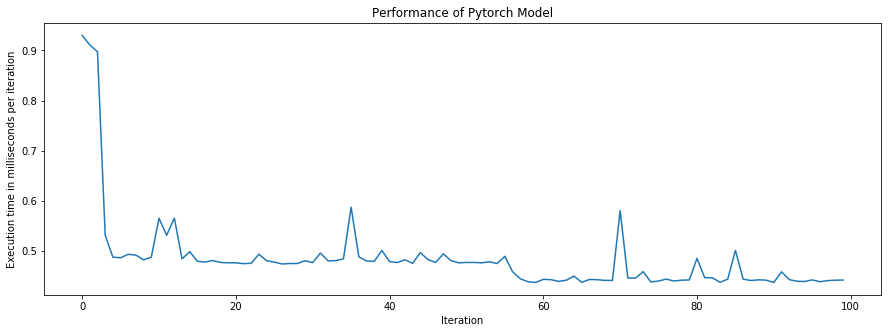

In [16]:
plt.figure(figsize=(15,5))
performce_models_dict['pytorch']=performance_pytorch_model(pytorch_model, inputs,warmup_iters=3,main_iters=100)
plt.plot(performce_models_dict['pytorch'])
plt.ylabel('Execution time in milliseconds per iteration')
plt.xlabel('Iteration')
plt.title('Performance of Pytorch Model')
plt.show()

The Caffe2 model execution time per iter is 1.9446182250976562 milliseconds, 514.2397551837103 iters per second.


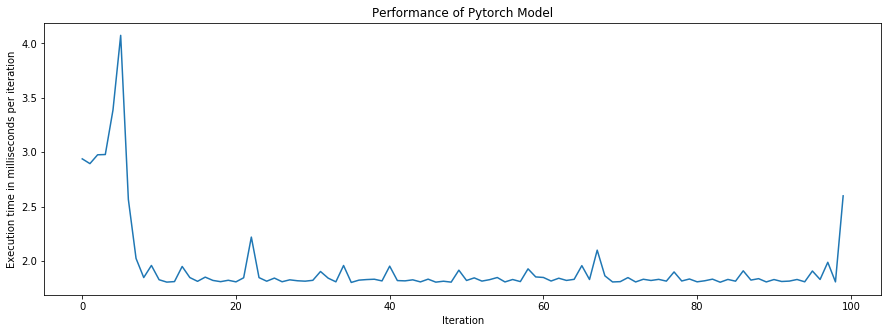

In [17]:
plt.figure(figsize=(15,5))
performce_models_dict['caffe2']=performance_caffe2_model(init_net, predict_net,caffe2_inputs, warmup_iters=3, main_iters=100)
plt.plot(performce_models_dict['caffe2'])
plt.ylabel('Execution time in milliseconds per iteration')
plt.xlabel('Iteration')
plt.title('Performance of Pytorch Model')
plt.show()

The Tensorflow model execution time per iter is 18.35378646850586 milliseconds, 54.48467005519258 iters per second.


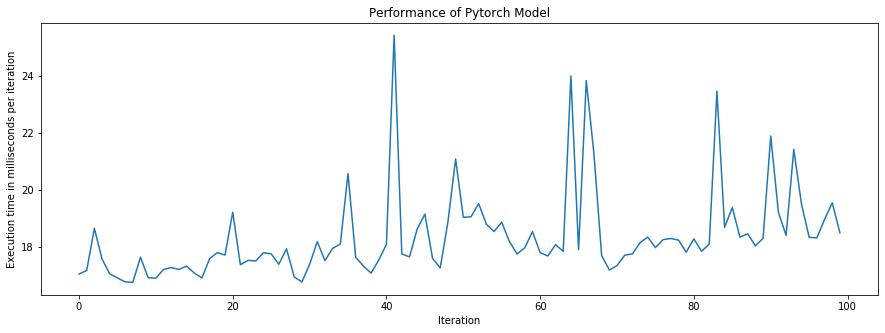

In [18]:
plt.figure(figsize=(15,5))
performce_models_dict['tensorflow']=performance_tensorflow_model(onnx_model, tensorflow_inputs, warmup_iters=3,main_iters=100)
plt.plot(performce_models_dict['tensorflow'])
plt.ylabel('Execution time in milliseconds per iteration')
plt.xlabel('Iteration')
plt.title('Performance of Tensorflow Model')
plt.show()

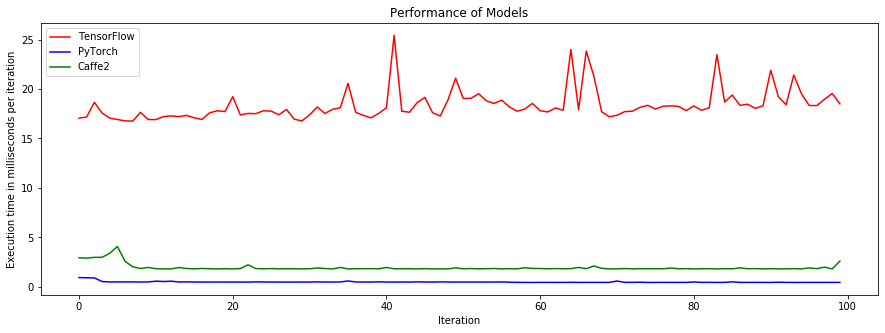

In [19]:
plt.figure(figsize=(15,5))
plt.plot(performce_models_dict['tensorflow'], 'r', label= 'TensorFlow')
plt.plot(performce_models_dict['pytorch'],'b', label= 'PyTorch')
plt.plot(performce_models_dict['caffe2'],'g', label = 'Caffe2')

plt.ylabel('Execution time in milliseconds per iteration')
plt.xlabel('Iteration')
plt.title('Performance of Models')
plt.legend()
plt.show()